<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

# Hyperparameters and Model Validation

The basic recipe for applying a supervised machine learning model (or any model, really) is:

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.
In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.
While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

### Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data.
We will start by loading the data:

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [1]:
iris = sns.load_dataset("iris")
iris.head()

NameError: name 'sns' is not defined

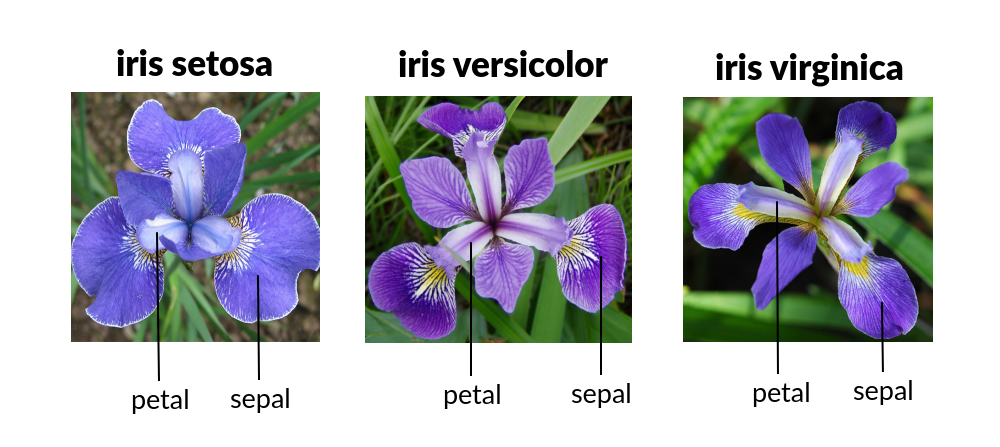

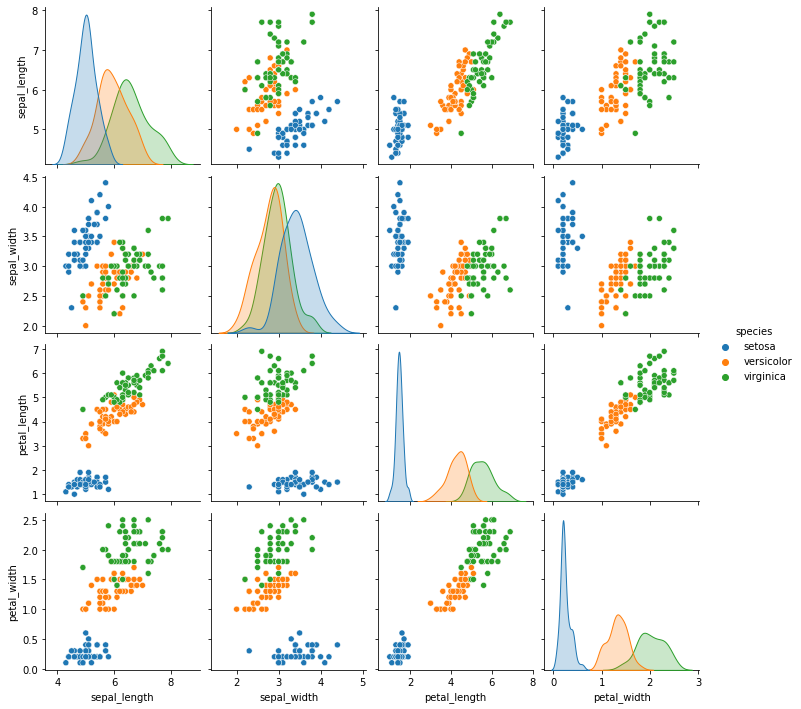

In [ ]:
import seaborn as sns
iris = sns.load_dataset("iris")
sns.pairplot(data=iris,hue='species')

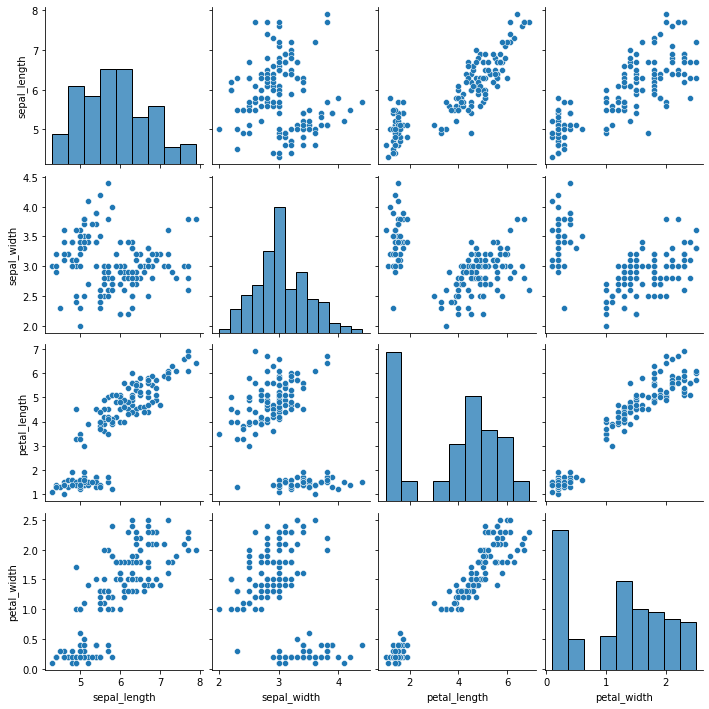

In [ ]:
sns.pairplot(data=iris)

Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [ ]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

### Model validation the right way: Holdout sets

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

In [ ]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

In [ ]:
%%%%%%%%%%
% MATLAB
%%%%%%%%%%

% Sample data (54000 x 10)
data = rand(54000,10);
% Cross validation (train: 70%, test: 30%)
cv = cvpartition(size(data,1),'HoldOut',0.3);
idx = cv.test;
% Separate to training and test data
dataTrain = data(~idx,:);
dataTest  = data(idx,:);

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-2-fold-CV.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#2-Fold-Cross-Validation)

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

In [ ]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

In [ ]:
%%%%%%%%%%
% MATLAB
%%%%%%%%%%

load('fisheriris');
CVO = cvpartition(150,'KFold',2)
err = zeros(CVO.NumTestSets,1);
for i = 1:CVO.NumTestSets
    trIdx = CVO.training(i);
    teIdx = CVO.test(i);
    ytest = classify(meas(teIdx,:),meas(trIdx,:),...
		 species(trIdx,:));
    err(i) = sum(~strcmp(ytest,species(teIdx)));
end
cvErr = sum(err)/sum(CVO.TestSize);
cvAcc = 1-cvErr

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-5-fold-CV.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#5-Fold-Cross-Validation)

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [ ]:
%%%%%%%%%%
% MATLAB
%%%%%%%%%%

load('fisheriris');
CVO = cvpartition(150,'KFold',5)
err = zeros(CVO.NumTestSets,1);
for i = 1:CVO.NumTestSets
    trIdx = CVO.training(i);
    teIdx = CVO.test(i);
    ytest = classify(meas(teIdx,:),meas(trIdx,:),...
		 species(trIdx,:));
    err(i) = sum(~strcmp(ytest,species(teIdx)));
end
cvErr = sum(err)/sum(CVO.TestSize);
cvAcc = 1-cvErr

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

In [ ]:
from sklearn.model_selection import  LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [ ]:
scores.mean()

0.96

In [ ]:
%%%%%%%%%%
% MATLAB
%%%%%%%%%%

load('fisheriris');
CVO = cvpartition(150,'Leaveout')
err = zeros(CVO.NumTestSets,1);
for i = 1:CVO.NumTestSets
    trIdx = CVO.training(i);
    teIdx = CVO.test(i);
    ytest = classify(meas(teIdx,:),meas(trIdx,:),...
		 species(trIdx,:));
    err(i) = sum(~strcmp(ytest,species(teIdx)));
end
err
cvErr = sum(err)/sum(CVO.TestSize);
cvAcc = 1-cvErr

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Selecting the Best Model

Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning (or modeling in general!), and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

- Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off

Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff)

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

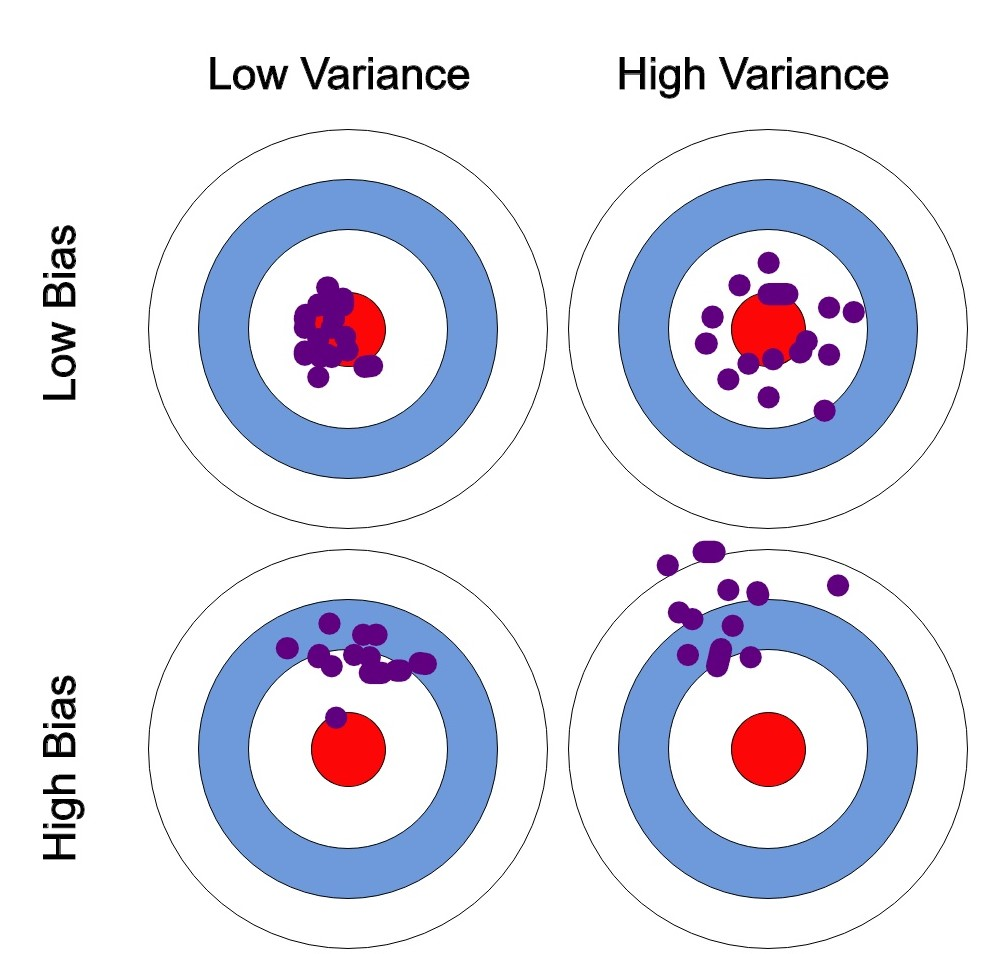

Text(0.5, 1.0, 'High-variance model: Overfits the data')

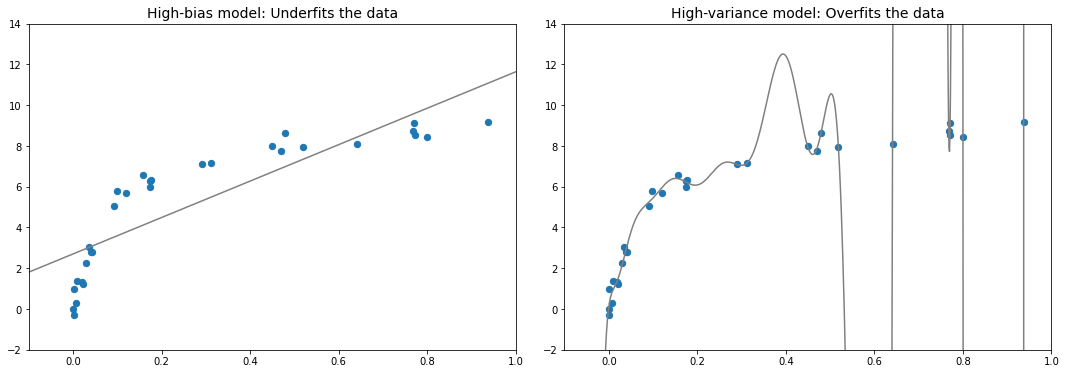

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Change # of N
# Change Error Term!

def make_data(N=30, err=.5, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))
X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)

The better the linear regression (on the right) fits the data in comparison to the simple average (on the left graph), the closer the value of is to 1. The areas of the blue squares represent the squared residuals with respect to the linear regression. The areas of the red squares represent the squared residuals with respect to the average value.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance-2.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff-Metrics)

The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

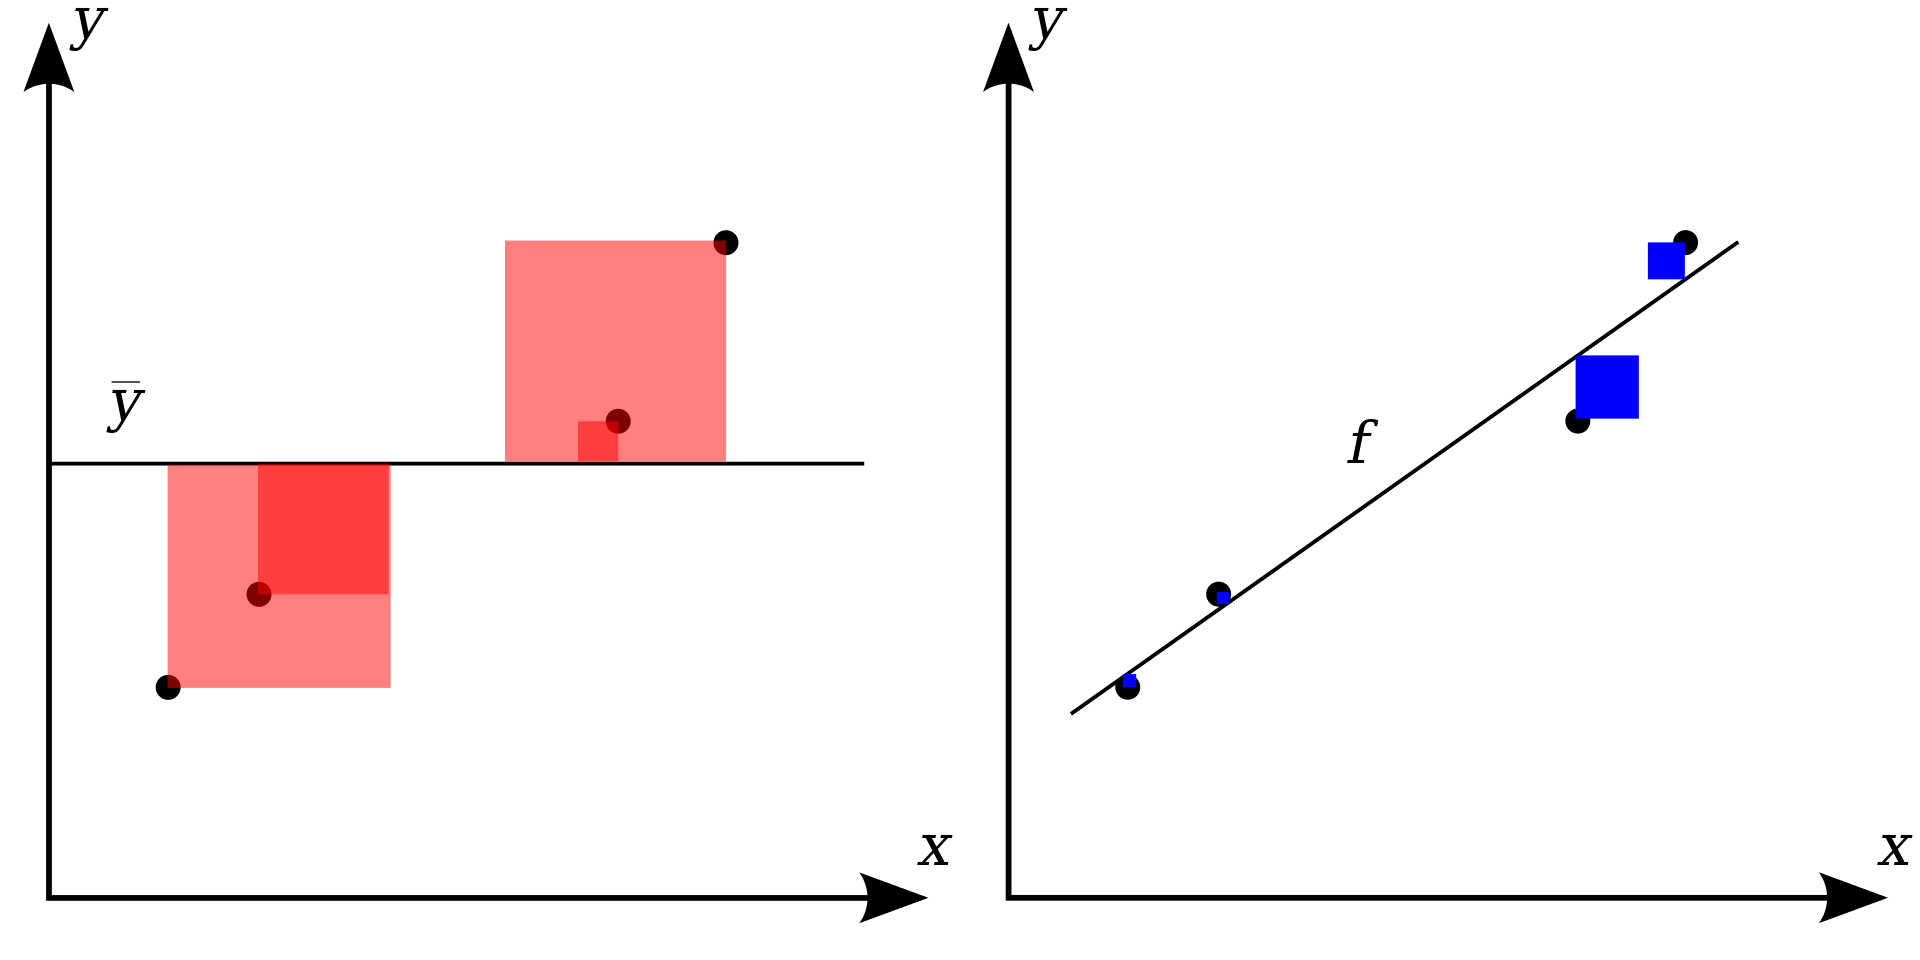



Text(0.02, 0.91, 'validation score: $R^2$ = -7.5e+08')

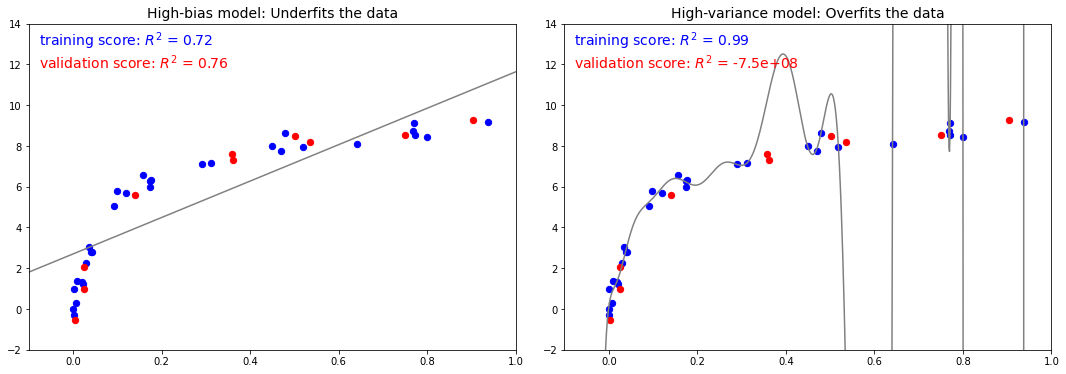

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')

## Why R^2 is a Poor Metric in General, Though!


R^2 will only go up as additional features are added, even if those features provide the model no new predictive power. See the example below, where completley random data with increasing columns is created, along with an R2 calculated.

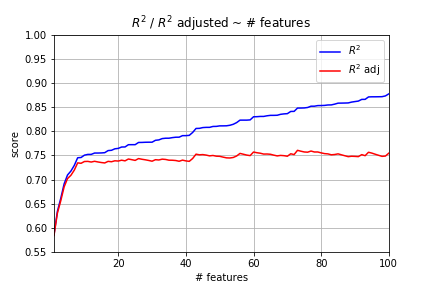

Ouch! That’s bad news. We generated random data. There’s absolutely no reason why including more features should lead to a better model. Yet, it’s clear from the plot above that R^2 only increases under these conditions. However, adjusted R^2 levels out because of the penalty involved.

The big takeaway here is that you cannot compare two linear regression models with differing numbers of features using R^2 alone. It just cannot be done. Adjusted R^2 works, though.

# What other ways can we quantify error? 
For classification problems, we have only used classification accuracy as our evaluation metric. What metrics can we used for regression problems?

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:

$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$
 
Mean Squared Error (MSE) is the mean of the squared errors:

$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$

 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$



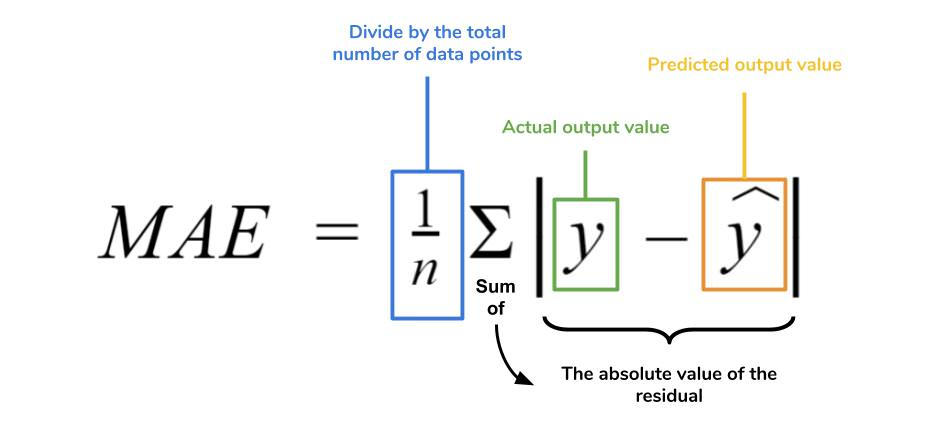

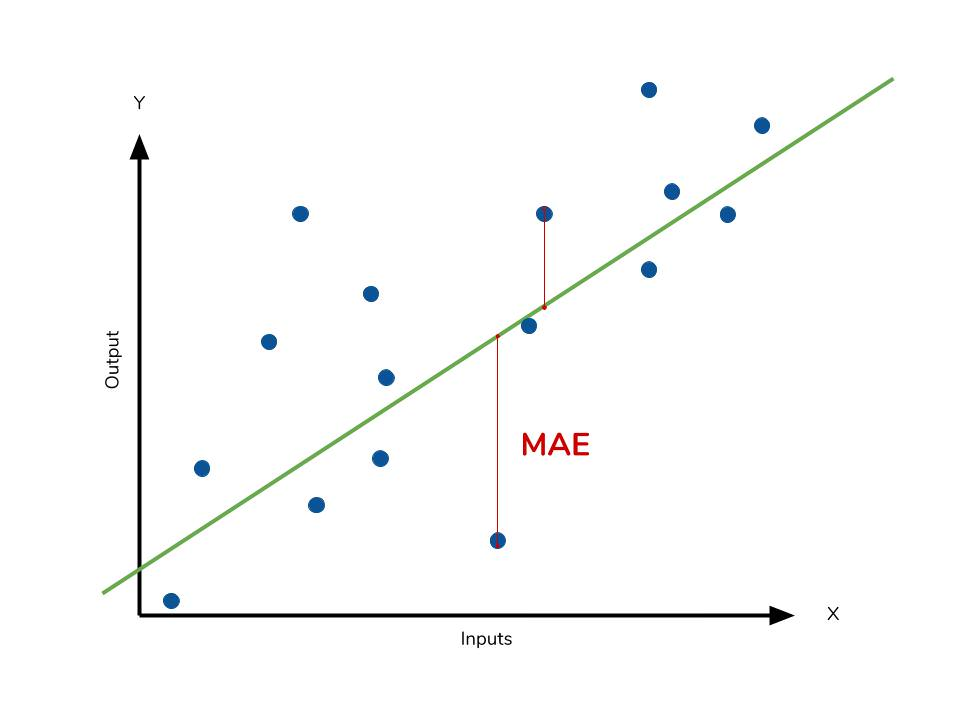

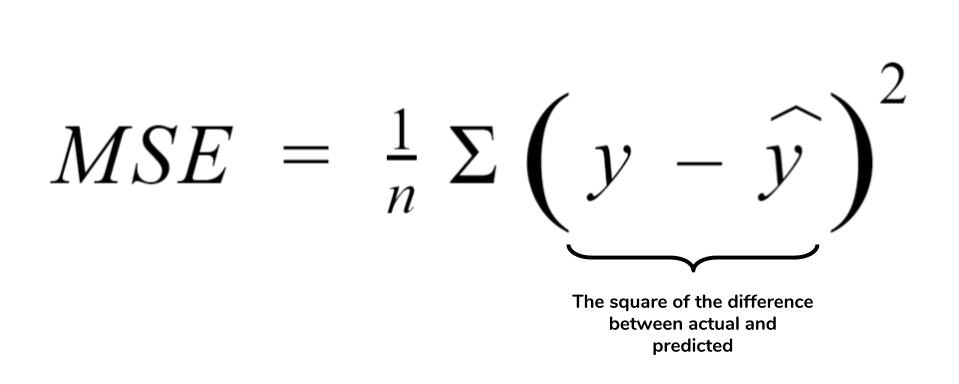

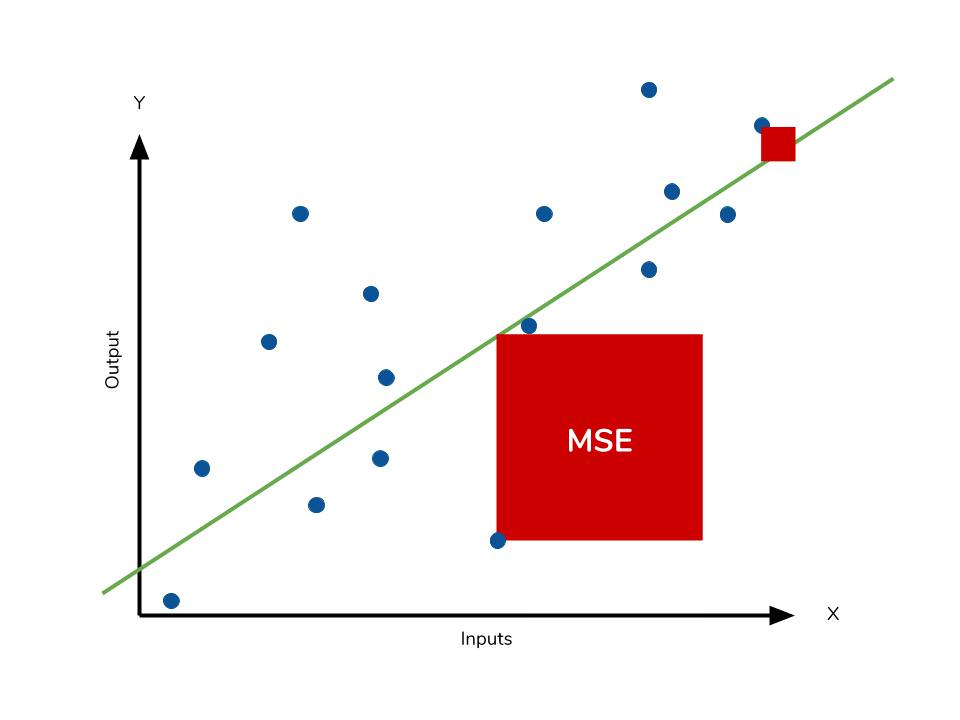

## Summary

In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.